In [148]:
# Path to google drive folder
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002. Laporan-eksperimen
# %cd /content/drive/MyDrive/Colab Notebooks/Disertasi-Ahmad-Rofiqul/002.Experiment_SWI_16052024/

In [149]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor, DMatrix, cv
import matplotlib.pyplot as plt

# from sklearn.ensemble import IsolationForest, VotingClassifier
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.svm import OneClassSVM
# from sklearn.covariance import EllipticEnvelope
# from pyod.models.hbos import HBOS
# from sklearn.cluster import DBSCAN
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, roc_curve, auc
# from sklearn.model_selection import train_test_split
# from sklearn.base import BaseEstimator, OutlierMixin
# from scipy.spatial.distance import mahalanobis

In [150]:

# Load the dataset
# df = pd.read_csv('/mnt/data/09_06_0_N2O_Agriculture_TestTraining_IDO_CV.ipynb')
framework='IFBYLOF'
file_path = 'dataset/09_05_4_1_AgricultureOutliersVotingBasedResult_'+framework+'_ONLY.csv'
# file_path = 'dataset/09_05_4_1_AgricultureOutliersVotingBasedResult_IF_LOF_ONLY.csv'
df= pd.read_csv(file_path)

# Ensure all columns are of the appropriate type
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes
    elif not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].astype('float')

X = df.drop('N2O', axis=1)
y = df['N2O']

test_sizes = [0.2, 0.25, 0.3, 0.35]
results = []


In [151]:

# Define evaluation function
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Function to perform no cross-validation
def no_cross_validation(X_train, y_train, X_test, y_test, params):
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return evaluate_model(y_test, y_pred)

# # Function to perform sklearn cross_val_score
# def sklearn_cross_val_score_eval(X, y, params):
#     model = XGBRegressor(**params)
#     mae_scores = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
#     mse_scores = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
#     rmse_scores = np.sqrt(mse_scores)
#     r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
#     return mae_scores.mean(), mse_scores.mean(), rmse_scores.mean(), r2_scores.mean()

# Function to perform xgb.cv
def xgb_cv_eval(X, y, params):
    dtrain = DMatrix(X, label=y)
    cv_results = cv(params, dtrain, num_boost_round=100, nfold=5, metrics=['mae', 'rmse'], early_stopping_rounds=10, seed=42)
    mae = cv_results['test-mae-mean'].iloc[-1]
    rmse = cv_results['test-rmse-mean'].iloc[-1]
    mse = rmse ** 2
    r2 = 1 - (mse / np.var(y))
    return mae, mse, rmse, r2


In [152]:
import time

## Perform No Tuning

In [153]:

def perform_notuning(X, y, test_size):
    results = []

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Method 1: No Cross Validation (Traditional Train-Test Split)
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Test Size': test_size,
        'Method': 'NoCV NoTuning',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

    # Method 2: XGBoost Cross-Validation (Using xgb.cv on the training set)
    dtrain = DMatrix(X_train, label=y_train)
    # xgb_params = {
    #     'max_depth': 3,
    #     'eta': 0.1,
    #     'objective': 'reg:squarederror',
    #     'n_estimators': 100,
    #     'random_state': 42
    # }
    xgb_params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.1,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        # 'n_estimators': 100,
        'seed': 42
    }
    # cv_results = xgb.cv(
    #     params=params,
    #     dtrain=dtrain,
    #     num_boost_round=100,
    #     nfold=5,
    #     metrics=['rmse'],
    #     as_pandas=True,
    #     seed=42,
    #     shuffle=True
    # )
    
    # rmse_cv = cv_results['test-rmse-mean'].iloc[-1]
    
    # Calculate MAE, MSE, and R2 using cross-validated predictions
    # Perform cross_val_predict on the training data to get predictions
    # y_cv_pred = cross_val_predict(model, X_train, y_train, cv=5, n_jobs=-1)
    
    # mae_cv = mean_absolute_error(y_train, y_cv_pred)
    # mse_cv = mean_squared_error(y_train, y_cv_pred)
    # r2_cv = r2_score(y_train, y_cv_pred)
    mae, mse, rmse, r2 = xgb_cv_eval(X, y, xgb_params)
    results.append({
        'Test Size': test_size,
        'Method': 'XGB.CV NoTuning',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

    return results


In [154]:

# Example usage with different test sizes
test_sizes = [0.2, 0.25, 0.3, 0.35]
all_results = []

for test_size in test_sizes:
    all_results.extend(perform_notuning(X, y, test_size))

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(all_results)
# import ace_tools as tools; tools.display_dataframe_to_user(name="Improved NoTuning Results with Different Test Sizes", dataframe=results_df)
print(results_df)


   Test Size           Method       MAE         MSE       RMSE        R2
0       0.20    NoCV NoTuning  6.579942  624.412880  24.988255  0.344518
1       0.20  XGB.CV NoTuning  6.419516  478.851602  21.882678  0.409714
2       0.25    NoCV NoTuning  6.154405  499.121843  22.341035  0.356294
3       0.25  XGB.CV NoTuning  6.419516  478.851602  21.882678  0.409714
4       0.30    NoCV NoTuning  6.107519  469.608478  21.670452  0.340632
5       0.30  XGB.CV NoTuning  6.419516  478.851602  21.882678  0.409714
6       0.35    NoCV NoTuning  6.298582  641.457733  25.327016  0.446154
7       0.35  XGB.CV NoTuning  6.419516  478.851602  21.882678  0.409714


In [155]:
# result_df = pd.concat(results_df, ignore_index=True)
result_df=pd.DataFrame(results_df)
# result_df.to_csv('dataset/0908_0_1_00_xgboost_evaluation_NoTuning_IFLOF_XGBCV.csv', index=False)
result_df.to_csv('dataset/0908_0_1_00_xgboost_evaluation_NoTuning_'+framework+'_XGBCV.csv', index=False)


In [156]:
# Grid Search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

In [157]:
param_grid2 = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5, 0.7, 1.0],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

## Perform Grid Search

In [158]:
# Function to perform hyperparameter tuning and evaluation
def perform_gridsearch(X, y, test_size,param_grid):
    results = {'Test Size': [], 'Method': [], 'Best Params': [], 'Start Time': [], 'End Time': [], 'Duration (s)': [], 'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
  
    grid_search = GridSearchCV(
        estimator=XGBRegressor(n_estimators=100, random_state=42),
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1,
        verbose=0,
        return_train_score=True
    )
    
    start_time = time.time()
    start_time_str = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))
    print(f"Starting Grid Search for test size {test_size}...")
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    end_time_str = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))
    duration = end_time - start_time
    print(f"Grid Search completed in {duration:.2f} seconds.")
    best_params = grid_search.best_params_
    print(f"Best parameters from Grid Search: {best_params}")

    # Plot Grid Search process
    # plt.figure(figsize=(12, 6))
    # plt.plot(-grid_search.cv_results_['mean_test_score'], marker='o', label='Mean Test Score (MSE)')
    # plt.plot(-grid_search.cv_results_['mean_train_score'], marker='o', label='Mean Train Score (MSE)')
    # plt.xlabel('Parameter Combination Index')
    # plt.ylabel('Mean Squared Error (MSE)')
    # plt.title(f'Grid Search Evaluation - Test Size: {test_size}')
    # plt.legend()
    # plt.show()

    # No Cross Validation
    mae, mse, rmse, r2 = no_cross_validation(X_train, y_train, X_test, y_test, best_params)
    results['Test Size'].append(test_size)
    results['Method'].append('No Cross Validation (Grid Search)')
    results['Best Params'].append(best_params)
    results['Start Time'].append(start_time_str)
    results['End Time'].append(end_time_str)
    results['Duration (s)'].append(duration)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)

   
    # xgb.cv
    xgb_params = best_params.copy()
    xgb_params['objective'] = 'reg:squarederror'
    mae, mse, rmse, r2 = xgb_cv_eval(X, y, xgb_params)
    results['Test Size'].append(test_size)
    results['Method'].append('xgb.cv (Grid Search)')
    results['Best Params'].append(best_params)
    results['Start Time'].append(start_time_str)
    results['End Time'].append(end_time_str)
    results['Duration (s)'].append(duration)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)

    # Store the Random Search process scores
    test_scores = -grid_search.cv_results_['mean_test_score']
    train_scores = -grid_search.cv_results_['mean_train_score']
    
    return pd.DataFrame(results),test_scores, train_scores

## Perform Random Search

In [159]:
# Function to perform hyperparameter tuning and evaluation
def perform_randomsearch(X, y, test_size,param_grid):
    results = {'Test Size': [], 'Method': [], 'Best Params': [], 'Start Time': [], 'End Time': [], 'Duration (s)': [], 'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    
    random_search = RandomizedSearchCV(
        estimator=XGBRegressor(n_estimators=100, random_state=42),
        param_distributions=param_grid,
        n_iter=50,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1,
        verbose=0,
        random_state=42,
        return_train_score=True
    )
    
    start_time = time.time()
    start_time_str = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))
    print(f"Starting Random Search for test size {test_size}...")
    random_search.fit(X_train, y_train)
    end_time = time.time()
    end_time_str = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))
    duration = end_time - start_time
    print(f"Random Search completed in {duration:.2f} seconds.")
    best_params = random_search.best_params_
    print(f"Best parameters from Random Search: {best_params}")



    # # Plot Random Search process
    # plt.figure(figsize=(12, 6))
    # plt.plot(-random_search.cv_results_['mean_test_score'], marker='o', label='Mean Test Score (MSE)')
    # plt.plot(-random_search.cv_results_['mean_train_score'], marker='o', label='Mean Train Score (MSE)')
    # plt.xlabel('Parameter Combination Index')
    # plt.ylabel('Mean Squared Error (MSE)')
    # plt.title(f'Random Search Evaluation - Test Size: {test_size}')
    # plt.legend()
    # plt.show()
    
    # No Cross Validation
    mae, mse, rmse, r2 = no_cross_validation(X_train, y_train, X_test, y_test, best_params)
    results['Test Size'].append(test_size)
    results['Method'].append('No Cross Validation (Random Search)')
    results['Best Params'].append(best_params)
    results['Start Time'].append(start_time_str)
    results['End Time'].append(end_time_str)
    results['Duration (s)'].append(duration)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)

    
    # xgb.cv
    xgb_params = best_params.copy()
    xgb_params['objective'] = 'reg:squarederror'
    mae, mse, rmse, r2 = xgb_cv_eval(X, y, xgb_params)
    results['Test Size'].append(test_size)
    results['Method'].append('xgb.cv (Random Search)')
    results['Best Params'].append(best_params)
    results['Start Time'].append(start_time_str)
    results['End Time'].append(end_time_str)
    results['Duration (s)'].append(duration)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R2'].append(r2)

    # Store the Random Search process scores
    test_scores = -random_search.cv_results_['mean_test_score']
    train_scores = -random_search.cv_results_['mean_train_score']
    
    return pd.DataFrame(results), test_scores, train_scores
    # return results

In [161]:
# Perform testing for each test size and optimization method
gridsearch = []

for test_size in test_sizes:
    results_df = perform_gridsearch(X, y, test_size,param_grid)
    
    # results = perform_randomsearch(X, y, test_size)
    # gridsearch.append(pd.DataFrame(results))
    gridsearch.append(results_df)

gridsearch

Starting Grid Search for test size 0.2...
Grid Search completed in 30.39 seconds.
Best parameters from Grid Search: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8}
Starting Grid Search for test size 0.25...
Grid Search completed in 40.22 seconds.
Best parameters from Grid Search: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.9}
Starting Grid Search for test size 0.3...
Grid Search completed in 39.21 seconds.
Best parameters from Grid Search: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7}
Starting Grid Search for test size 0.35...
Grid Search completed in 40.38 seconds.
Best parameters from Grid Search: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9}


[(   Test Size                             Method  \
  0        0.2  No Cross Validation (Grid Search)   
  1        0.2               xgb.cv (Grid Search)   
  
                                           Best Params           Start Time  \
  0  {'colsample_bytree': 0.9, 'learning_rate': 0.1...  2024-06-09 01:45:42   
  1  {'colsample_bytree': 0.9, 'learning_rate': 0.1...  2024-06-09 01:45:42   
  
                End Time  Duration (s)       MAE         MSE       RMSE  \
  0  2024-06-09 01:46:12     30.391584  6.663882  465.689840  21.579848   
  1  2024-06-09 01:46:12     30.391584  6.638253  497.405989  22.302601   
  
           R2  
  0  0.511139  
  1  0.386842  ,
  array([615.06343642, 620.86334716, 622.59267513, 601.15260724,
         603.48055792, 602.83334966, 595.03175393, 594.46090257,
         593.4142973 , 592.27847784, 588.80994371, 590.39451134,
         585.129592  , 576.68423524, 569.32372687, 571.33839358,
         570.731259  , 564.68716488, 589.84379009, 587.186012

In [166]:
# final_results_df = pd.concat(gridsearch)
# final_results_df = gridsearch
final_results_df=pd.DataFrame(gridsearch)
final_results_df.to_csv('dataset/0908_0_1_00_xgboost_evaluation_CV_GridSearch_'+framework+'_XGBCV.csv', index=False)


In [ ]:
# final_results_df

In [ ]:
# final_results_df.to_csv('dataset/0908_0_1_xgboost_evaluation_CV_GridSearch_IDO.csv', index=False)


In [167]:
# Perform testing for each test size and optimization method
# random_results = []
all_results = []
test_scores_dict = {}
train_scores_dict = {}
for test_size in test_sizes:
    # results = perform_gridsearch(X, y, test_size)
    # results = perform_randomsearch(X, y, test_size,param_grid2)
    results_df, test_scores, train_scores = perform_randomsearch(X, y, test_size, param_grid2)
    test_scores_dict[test_size] = test_scores
    train_scores_dict[test_size] = train_scores
    # random_results.append(pd.DataFrame(results))
    all_results.append(results_df)


# Combine all results into a single DataFrame
# random_results_df = pd.concat(random_results, ignore_index=True)
# random_results_df

Starting Random Search for test size 0.2...
Random Search completed in 10.02 seconds.
Best parameters from Random Search: {'subsample': 0.5, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Starting Random Search for test size 0.25...
Random Search completed in 10.22 seconds.
Best parameters from Random Search: {'subsample': 0.5, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Starting Random Search for test size 0.3...
Random Search completed in 10.82 seconds.
Best parameters from Random Search: {'subsample': 0.5, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Starting Random Search for test size 0.35...
Random Search completed in 11.50 seconds.
Best parameters from Random Search: {'subsample': 0.5, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [168]:
all_results

[   Test Size                               Method  \
 0        0.2  No Cross Validation (Random Search)   
 1        0.2               xgb.cv (Random Search)   
 
                                          Best Params           Start Time  \
 0  {'subsample': 0.5, 'min_child_weight': 5, 'max...  2024-06-09 01:53:04   
 1  {'subsample': 0.5, 'min_child_weight': 5, 'max...  2024-06-09 01:53:04   
 
               End Time  Duration (s)       MAE         MSE       RMSE  \
 0  2024-06-09 01:53:14     10.022809  6.755103  424.244701  20.597201   
 1  2024-06-09 01:53:14     10.022809  6.644683  433.814725  20.828219   
 
          R2  
 0  0.554646  
 1  0.465231  ,
    Test Size                               Method  \
 0       0.25  No Cross Validation (Random Search)   
 1       0.25               xgb.cv (Random Search)   
 
                                          Best Params           Start Time  \
 0  {'subsample': 0.5, 'min_child_weight': 5, 'max...  2024-06-09 01:53:14   
 1  {'subs

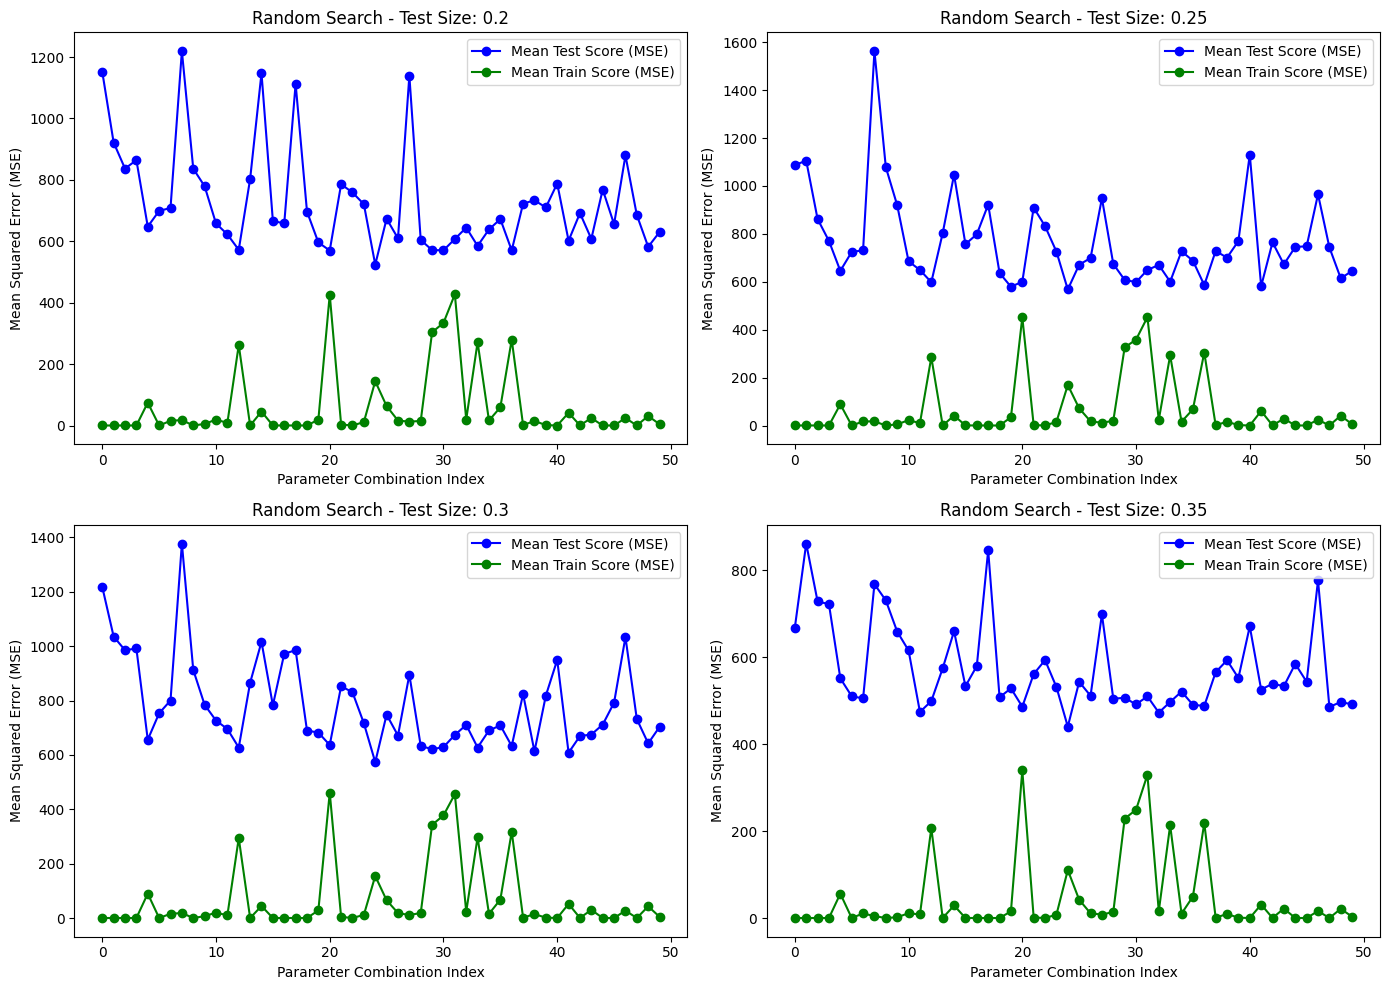

Figure saved to visual/0908_IFBYLOF_HyperparameterTuning_random_search_comparison.jpg


In [169]:
# Combine all results into a single DataFrame
random_results_df = pd.concat(all_results)

# Plot the collected scores in a 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to iterate easily

for idx, test_size in enumerate(test_sizes):
    ax = axes[idx]
    ax.plot(test_scores_dict[test_size], marker='o', label='Mean Test Score (MSE)', color='b')
    ax.plot(train_scores_dict[test_size], marker='o', label='Mean Train Score (MSE)', color='g')
    
    ax.set_xlabel('Parameter Combination Index')
    ax.set_ylabel('Mean Squared Error (MSE)')
    ax.set_title(f'Random Search - Test Size: {test_size}')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the combined figure as a JPG file with 300 DPI resolution
output_path = 'visual/0908_'+framework+'_HyperparameterTuning_random_search_comparison.jpg'
plt.savefig(output_path, dpi=300)

# Display the combined figure
plt.show()

print(f"Figure saved to {output_path}")

In [170]:
random_results_df.to_csv('dataset/0908_0_2_00_xgboost_evaluation_CV_RandomSearch_'+framework+'_XGBCV.csv', index=False)


In [171]:

# Display the DataFrame
# import ace_tools as tools; tools.display_dataframe_to_user(name="Hyperparameter Tuning Results", dataframe=final_results_df)

# Visualization of performance metrics
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
methods = final_results_df['Method'].unique()
colors = ['b', 'g', 'r', 'c', 'm']  # Adjust or expand this list as needed

for metric in metrics:
    plt.figure(figsize=(12, 8))
    for i, method in enumerate(methods):
        subset = final_results_df[final_results_df['Method'] == method]
        plt.bar(subset['Test Size'] + i * 0.02, subset[metric], width=0.02, label=method, color=colors[i % len(colors)])
        
        for x, y in zip(subset['Test Size'], subset[metric]):
            plt.text(x + i * 0.02, y, f'{y:.5f}', ha='center', va='bottom', fontsize=9)

    plt.xlabel('Test Size')
    plt.ylabel(metric)
    plt.title(f'Comparison of {metric} for Different Hyperparameter Tuning Methods')
    plt.xticks(test_sizes)
    plt.legend()
    plt.show()


KeyError: 'Method'

In [172]:
# Assume final_results_df is already defined and contains the necessary data
# Define metrics, methods, and colors
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
methods = final_results_df['Method'].unique()
colors = ['b', 'g', 'r', 'c', 'm']  # Adjust or expand this list as needed

# Set up the figure and axes for a 2x2 grid layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to iterate easily

# Loop through the metrics and plot each on a separate subplot
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    for i, method in enumerate(methods):
        subset = final_results_df[final_results_df['Method'] == method]
        ax.bar(subset['Test Size'] + i * 0.02, subset[metric], width=0.02, label=method, color=colors[i % len(colors)])
        
        # Add text annotations
        for x, y in zip(subset['Test Size'], subset[metric]):
            ax.text(x + i * 0.02, y, f'{y:.5f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Test Size')
    ax.set_ylabel(metric)
    ax.set_title(f'Comparison of {metric}')
    ax.set_xticks(test_sizes)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as a JPG file with 300 DPI resolution
output_path = 'visual/0908_0_'+framework+'_XGBCV_GridSearch_comparison.jpg'
plt.savefig(output_path, dpi=300)

# Display the figure
plt.show()

print(f"Figure saved to {output_path}")

KeyError: 'Method'

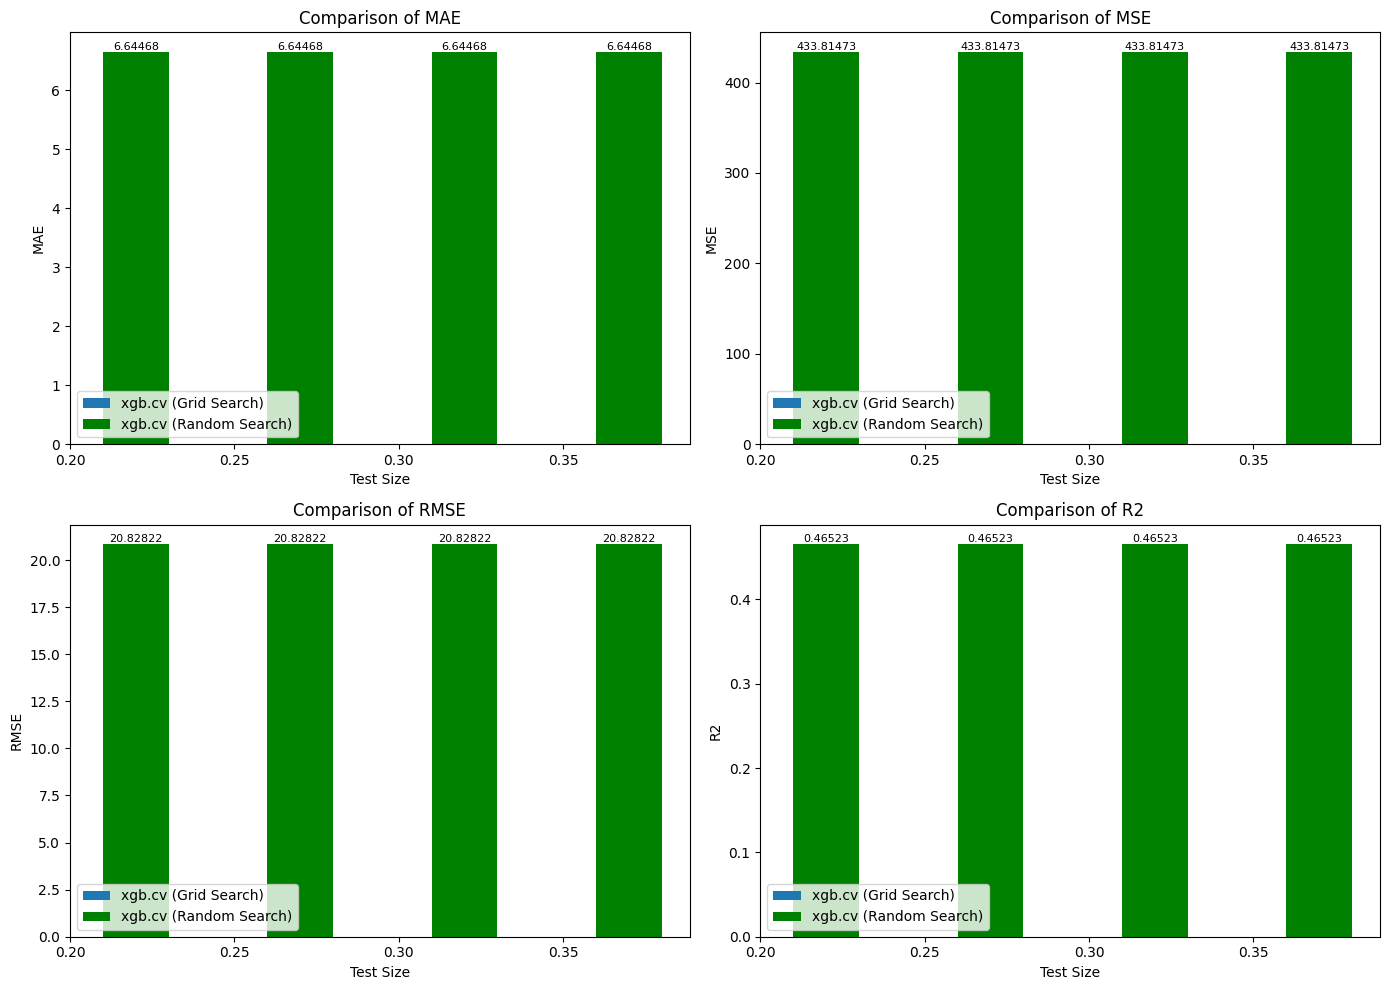

Figure saved to visual/0908_0_IFBYLOF_hyperparameter_tuning_comparison_with_random_search.jpg


In [173]:
# Example: Load the data (replace with actual file paths or DataFrame creation as needed)
# final_results_df = pd.read_csv('path_to_grid_search_results.csv')
# random_results_df = pd.read_csv('path_to_random_search_results.csv')

# Combine the data from Grid Search and Random Search for comparison
combined_df = pd.concat([final_results_df, random_results_df])

# Define metrics, methods, and colors
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
methods = ['xgb.cv (Grid Search)', 'xgb.cv (Random Search)']
colors = ['r', 'g', 'r', 'c', 'm']  # Adjust or expand this list as needed

# Set up the figure and axes for a 2x2 grid layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to iterate easily

# Loop through the metrics and plot each on a separate subplot
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    for i, method in enumerate(methods):
        subset = combined_df[combined_df['Method'] == method]
        ax.bar(subset['Test Size'] + i * 0.02, subset[metric], width=0.02, label=method, color=colors[i % len(colors)])
        
        # Add text annotations
        for x, y in zip(subset['Test Size'], subset[metric]):
            ax.text(x + i * 0.02, y, f'{y:.5f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Test Size')
    ax.set_ylabel(metric)
    ax.set_title(f'Comparison of {metric}')
    ax.set_xticks(test_sizes)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as a JPG file with 300 DPI resolution
output_path = 'visual/0908_0_'+framework+'_hyperparameter_tuning_comparison_with_random_search.jpg'
plt.savefig(output_path, dpi=300)

# Display the figure
plt.show()

print(f"Figure saved to {output_path}")